<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Review-and-Preparation" data-toc-modified-id="Data-Review-and-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Review and Preparation</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#Decomposition" data-toc-modified-id="Decomposition-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Decomposition</a></span></li><li><span><a href="#Stationarity-test" data-toc-modified-id="Stationarity-test-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Stationarity test</a></span></li></ul></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Features-Creation" data-toc-modified-id="Features-Creation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Features Creation</a></span></li><li><span><a href="#Data-split" data-toc-modified-id="Data-split-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data split</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Model-comparison" data-toc-modified-id="Model-comparison-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model comparison</a></span></li></ul></li><li><span><a href="#Sanity-Check" data-toc-modified-id="Sanity-Check-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sanity Check</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

#  Taxi orders prediction

The "XYZ Taxi" company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, we need to predict the number of taxi orders for the next hour. We need to build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

We need to:

1. Load the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test set of 10% of the original data.
4. Check the data on the test set.


The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column.

**The purpose of the project:** To build a model for a regression problem that predicts the number of taxi orders for the next hour.


**Project steps:**

1. Data Review and Preparation.
2. Data analysis.
3. Model training.
4. Model testing.
5. Sanity Check.

## Data Review and Preparation

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from catboost import CatBoostRegressor
from scipy import stats as st
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
warnings.filterwarnings("ignore")

In [3]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except: 
    print('Something is wrong')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Let's sort the timestamps, resample by 1 hour and check if the data is monotonic.

In [5]:
df.sort_index(inplace=True)

In [6]:
df = df.resample('1H').sum()

In [7]:
df.index.is_monotonic

True

In [8]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Conclusion

The dataset consists of 26496 observations and 1 column. We have a table with the quantity of taxi orders at airports from March 1, 2018 to August 31, 2018.

The data was resampled by one hour (aggregation was done using the `sum` method), the data index increases monotonically, there are no missing values in the data. We can start the analysis.

## Data analysis

Let's apply a 24-hour moving average to the data to smooth fluctuations in the data and identify trends.

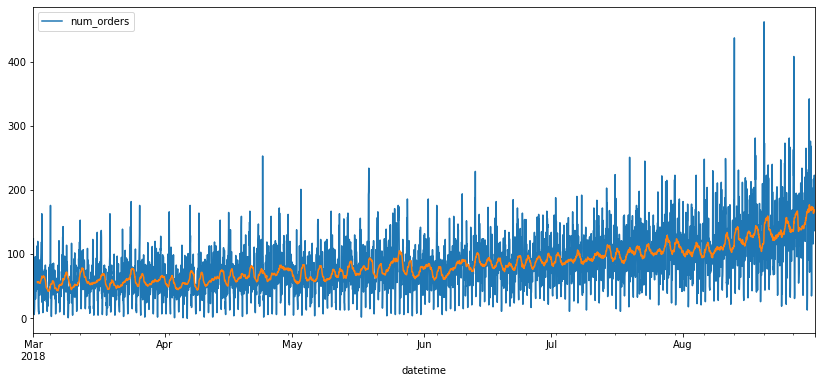

In [9]:
plt.figure(figsize=(14, 6))
df['num_orders'].plot()
df['num_orders'].rolling(24).mean().plot()
plt.legend(df)

plt.show()

According to the smoothed data, an uptrend can be seen, which may indicate the development of the company and an increase in the number of orders.

### Decomposition 

In order to better understand trends and seasonality, we will perform the decomposition of the time series and create graphs.

In [10]:
decomposed = seasonal_decompose(df) 

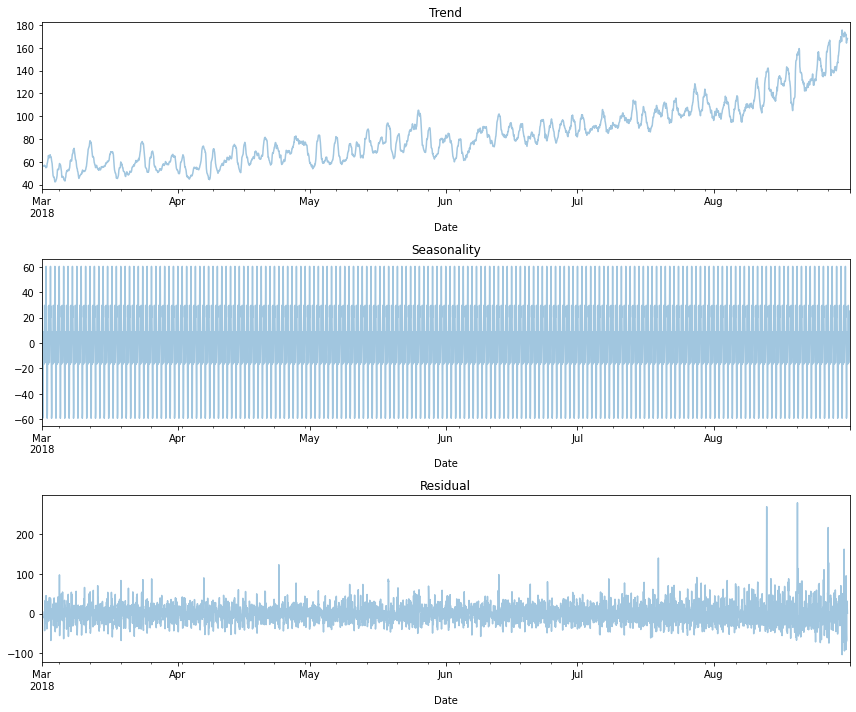

In [11]:
plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), alpha=.42)
plt.title('Trend')
plt.xlabel('Date')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), alpha=.42) 
plt.title('Seasonality')
plt.xlabel('Date')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), alpha=.42) 
plt.title('Residual')
plt.xlabel('Date')

plt.tight_layout()



The graphs show an upward trend, and seasonality by season is not observed. For a more detailed study, let's also look at charts for one month, one week, and one day.

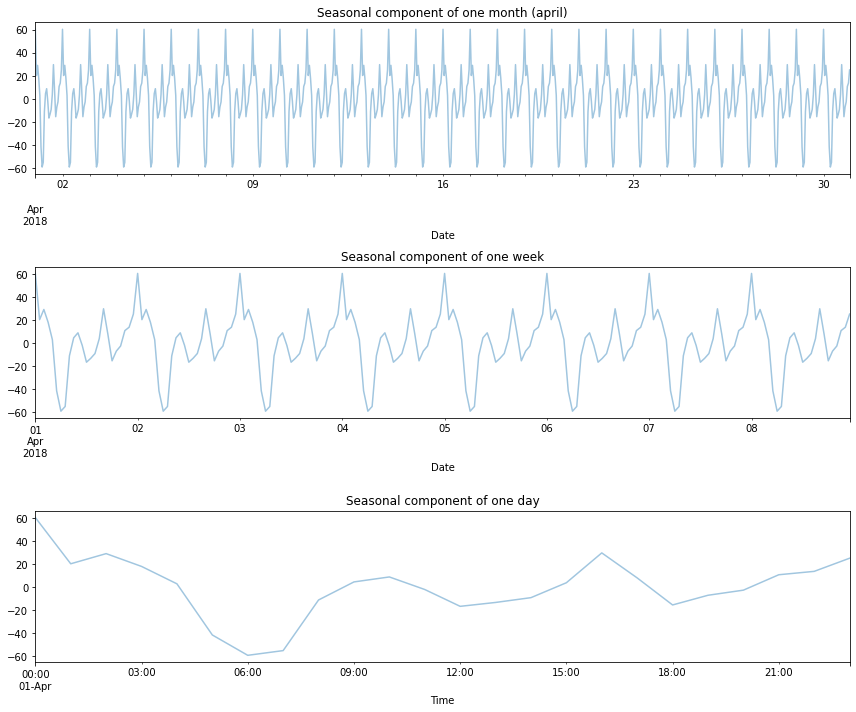

In [12]:
plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(ax=plt.gca(), alpha=.42) 
plt.title('Seasonal component of one month (april)')
plt.xlabel('Date')

plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-08'].plot(ax=plt.gca(), alpha=.42) 
plt.title('Seasonal component of one week')
plt.xlabel('Date')

plt.subplot(313)
decomposed.seasonal['2018-04-01':'2018-04-01'].plot(ax=plt.gca(), alpha=.42) 
plt.title('Seasonal component of one day')
plt.xlabel('Time')

plt.tight_layout()

There is a correlation between seasonality and time of day. Starting from midnight, we can observe a decline in the number of orders, and from 6 am an increase begins, which may be due to the work schedule of taxi users. At the same time, it should be noted that there are no dependencies on the day of the week (working days/weekends). 

### Stationarity test

Let's check our time series for stationarity.

In [13]:
unshifted_df = df.copy()

In [14]:
# Augmented Dickey–Fuller test
test = adfuller(df['num_orders'])
print(f'Test statistic: {test[0]} \n'
      f'p_value: {test[1]} \n'
      f'Critical Values: {test[4]} \n')

if test[0] > test[4]['1%']:
    print('A unit root is present, the time series is non-stationary')
else:
    print('A unit root is not present, the time series is stationary')

Test statistic: -3.0689242890279327 
p_value: 0.028940051402614794 
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452} 

A unit root is present, the time series is non-stationary


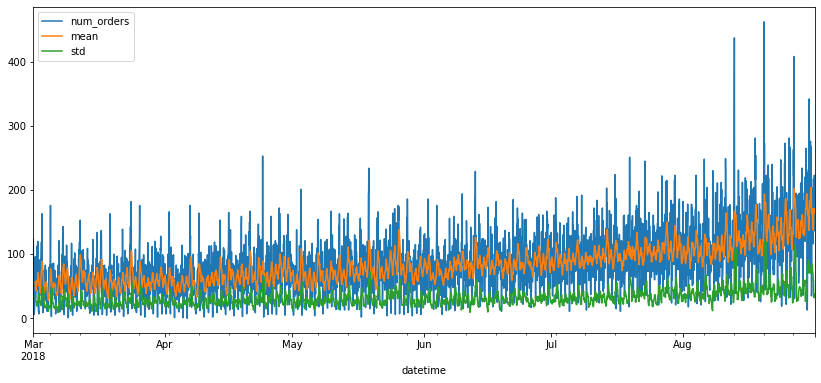

In [15]:
plt.figure(figsize=(14, 6))
unshifted_df['mean'] = unshifted_df['num_orders'].rolling(12).mean()
unshifted_df['std'] = unshifted_df['num_orders'].rolling(12).std()
unshifted_df.plot(ax=plt.gca()) 
plt.show()

There is an increase in the average values and standard deviation, as well as their fluctuations.

Let's find the differences in the values of the time series and look at the resulting graph.

In [16]:
shifted_df = df - df.shift()
shifted_df['mean'] = shifted_df['num_orders'].rolling(12).mean()
shifted_df['std'] = shifted_df['num_orders'].rolling(12).std()

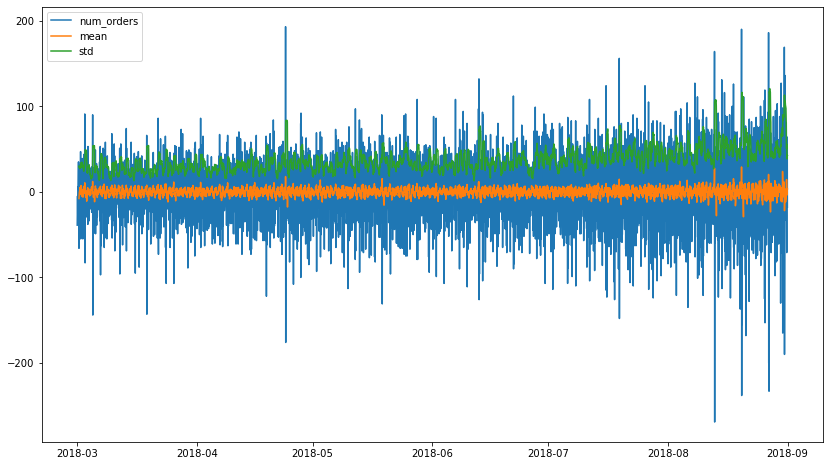

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(shifted_df)
plt.legend(shifted_df)
plt.show()

The time series became more stationary.

Let's apply the Augmented Dickey–Fuller test to check the time series for stationarity.

In [18]:
# Augmented Dickey–Fuller test
test = adfuller(shifted_df['num_orders'].dropna())
print(f'Test statistic: {test[0]} \n'
      f'p_value: {test[1]} \n'
      f'Critical Values: {test[4]} \n')

if test[0] > test[4]['1%']:
    print('A unit root is present, the time series is non-stationary')
else:
    print('A unit root is not present, the time series is stationary')

Test statistic: -15.793234257410628 
p_value: 1.0958776746506564e-28 
Critical Values: {'1%': -3.431842843698785, '5%': -2.8621996550511697, '10%': -2.56712113869159} 

A unit root is not present, the time series is stationary


Thus, a p-value less than 0.01 (rejecting the null hypothesis) indicates that the time series is stationary. We can start training models.

## Model Training

### Features Creation

First, let's write a function to create features necessary for training models.

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [20]:
make_features(df, 24, 3)

In [21]:
df.head(5)

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


Let's remove missing values.

In [22]:
df = df.dropna()

In [23]:
df.isna().sum()

num_orders      0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

### Data split

Let's divide the data into features and a target variable.

In [24]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

In [25]:
print('Features shape:',features.shape)
print('Target Variable shape:',target.shape)

Features shape: (4392, 26)
Target Variable shape: (4392,)


Let's split the data into two sets: training and testing. We will use the training set to train the model and to tune the hyperparameters, and the test set to test the model.

In [26]:
X_train , X_test , y_train , y_test = train_test_split (
                                                        features, target, shuffle=False, test_size = .1)

In [27]:
print('Features shape of the training set:', X_train.shape), 
print('Target variable shape of the training set:', y_train.shape), 
print('Features shape of the test set:', X_test.shape), 
print('Target variable shape of the test set:', y_test.shape)

Features shape of the training set: (3952, 26)
Target variable shape of the training set: (3952,)
Features shape of the test set: (440, 26)
Target variable shape of the test set: (440,)


We split the data into two sets in a ratio of 90 to 10:

     X_train, y_train - training set
     X_test, y_test - test set

Let's create lists to add model results to them. In the end, we will create a table and analyze the results. 

In [28]:
model_rmse_train = []
model_rmse_test = []
model_name = []

### Linear Regression

Let's tune hyperparameters using GridSearchCV and train the model. For cross-validation, we will use `TimeSeriesSplit`, in order to avoid incorrect shuffling of samples.

In [29]:
tscv = TimeSeriesSplit(n_splits=3)

In [30]:
lr_params = {'fit_intercept':[True, False], 'normalize':[True, False]}

lr = LinearRegression()
grid_lr = GridSearchCV(lr, lr_params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_lr.fit(X_train, y_train)

lr_rmse_train = np.abs(grid_lr.best_score_)
print(f'The best RMSE for Linear Regression on the training data: {lr_rmse_train}')

The best RMSE for Linear Regression on the training data: 27.563639116353144


In [31]:
model_name.append('LinearRegression')
model_rmse_train.append(lr_rmse_train)

### Ridge

Let's tune hyperparameters using GridSearchCV and train the model.

In [32]:
ridge_params = {'alpha': [0.2, 0.4, 0.6, 0.8, 1], 'fit_intercept':[True, False], 'normalize':[True, False]}

model_ridge = Ridge()
grid_ridge = GridSearchCV(model_ridge, ridge_params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_ridge.fit(X_train, y_train)

ridge_rmse_train = np.abs(grid_ridge.best_score_)
print(f'The best RMSE for Ridge on the training data: {ridge_rmse_train}')

The best RMSE for Ridge on the training data: 27.5634270571049


In [33]:
model_name.append('Ridge')
model_rmse_train.append(ridge_rmse_train)

### Lasso

Let's tune hyperparameters using GridSearchCV and train the model.

In [34]:
lasso_params = {'alpha': [0.2, 0.4, 0.6, 0.8, 1], 'fit_intercept':[True, False], 'normalize':[True, False]}

model_lasso = linear_model.Lasso()
grid_lasso = GridSearchCV(model_lasso, lasso_params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_lasso.fit(X_train, y_train)

lasso_rmse_train = np.abs(grid_lasso.best_score_)
print(f'The best RMSE for Lasso on the training data: {lasso_rmse_train}')

The best RMSE for Lasso on the training data: 27.561862992591454


In [35]:
model_name.append('Lasso')
model_rmse_train.append(lasso_rmse_train)

### CatBoost

Let's tune hyperparameters using GridSearchCV and train the model.

In [36]:
grid_catboost_params = {'learning_rate': [0.2, 0.4], 
                        'depth': [4, 6, 10], 
                        'iterations': [100, 200], 
                        'random_seed': [12345], 
                        'verbose': [50]}

grid_catboost_model = CatBoostRegressor()
grid_catboost = GridSearchCV(grid_catboost_model, 
                             grid_catboost_params, 
                             cv=tscv, 
                             scoring='neg_root_mean_squared_error')

grid_catboost.fit(X_train, y_train)

0:	learn: 27.1858489	total: 157ms	remaining: 15.5s
50:	learn: 14.8751808	total: 256ms	remaining: 246ms
99:	learn: 11.8595994	total: 359ms	remaining: 0us
0:	learn: 29.2598157	total: 2.94ms	remaining: 291ms
50:	learn: 17.6405277	total: 147ms	remaining: 142ms
99:	learn: 15.2237695	total: 288ms	remaining: 0us
0:	learn: 31.0953956	total: 3.07ms	remaining: 304ms
50:	learn: 19.5292195	total: 221ms	remaining: 212ms
99:	learn: 17.3345075	total: 369ms	remaining: 0us
0:	learn: 25.3788215	total: 2.96ms	remaining: 293ms
50:	learn: 12.0613365	total: 106ms	remaining: 102ms
99:	learn: 8.1760428	total: 227ms	remaining: 0us
0:	learn: 26.9044791	total: 3.17ms	remaining: 314ms
50:	learn: 15.2885310	total: 189ms	remaining: 181ms
99:	learn: 12.0524528	total: 354ms	remaining: 0us
0:	learn: 28.6816092	total: 3.27ms	remaining: 324ms
50:	learn: 17.8529752	total: 144ms	remaining: 139ms
99:	learn: 14.9036360	total: 292ms	remaining: 0us
0:	learn: 27.1858489	total: 2.11ms	remaining: 421ms
50:	learn: 14.8751808	tota

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001EF88142CD0>,
             param_grid={'depth': [4, 6, 10], 'iterations': [100, 200],
                         'learning_rate': [0.2, 0.4], 'random_seed': [12345],
                         'verbose': [50]},
             scoring='neg_root_mean_squared_error')

In [37]:
catboost_rmse_train = np.abs(grid_catboost.best_score_)
print(f'RMSE of CatBoost on the training data: {catboost_rmse_train}')

RMSE of CatBoost on the training data: 26.968738577356387


In [38]:
model_name.append('CatBoostRegressor')
model_rmse_train.append(catboost_rmse_train)

### LightGBM

Let's list the feature names for LightGBM.

In [39]:
lgbm_features = list(X_train.columns)

lgbm_features

['dayofweek',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'rolling_mean']

In [40]:
X_train_lgbm = X_train.copy()

Let's tune hyperparameters using GridSearchCV and train the model.

In [41]:
train_data = lgb.Dataset (X_train_lgbm, 
                          label = y_train, 
                          feature_name = lgbm_features)


lgb_params = {'learning_rate': [0.2, 0.5], 'num_iterations': [100, 200]}


lgb_model = lgb.LGBMRegressor(random_state=12345)
grid_lgbm = GridSearchCV(lgb_model, 
                         lgb_params, 
                         cv=tscv, 
                         scoring='neg_root_mean_squared_error', 
                         verbose=False, 
                         n_jobs=-1) 

grid_lgbm.fit(X_train_lgbm, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5],
                         'num_iterations': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=False)

In [42]:
lgbm_rmse_train = np.abs(grid_lgbm.best_score_)
print(f'RMSE of LightGBM on the training data: {lgbm_rmse_train}')

RMSE of LightGBM on the training data: 27.82727667040444


In [43]:
model_name.append('LightGBM')
model_rmse_train.append(lgbm_rmse_train)

## Testing

In [44]:
def make_graph(model_pred, name, model_rmse): 
    plt.figure(figsize=(14, 8))
    plt.plot(model_pred, 'orange', label='predicted')
    plt.plot(y_test.values, label='actual', alpha=.5)
    plt.legend()
    plt.title(f'{name}\n RMSE {round(model_rmse)}')
    plt.grid(True)
    
    plt.figure(figsize=(14, 8))
    plt.plot(model_pred[:48], 'orange', label='predicted')
    plt.plot(y_test[:48].values, label='actual', alpha=.5)
    plt.legend()
    plt.title(f'{name}\n RMSE {round(model_rmse)}')
    plt.xticks(np.arange(0, 48, step=1))
    plt.grid(True)

**Linear Regression**

In [45]:
lr_pred = grid_lr.predict(X_test)

lr_rmse_test = mean_squared_error(y_test, lr_pred, squared=False)
model_rmse_test.append(lr_rmse_test)
print(f'RMSE on the test data: {lr_rmse_test}')

RMSE on the test data: 44.95890318988557


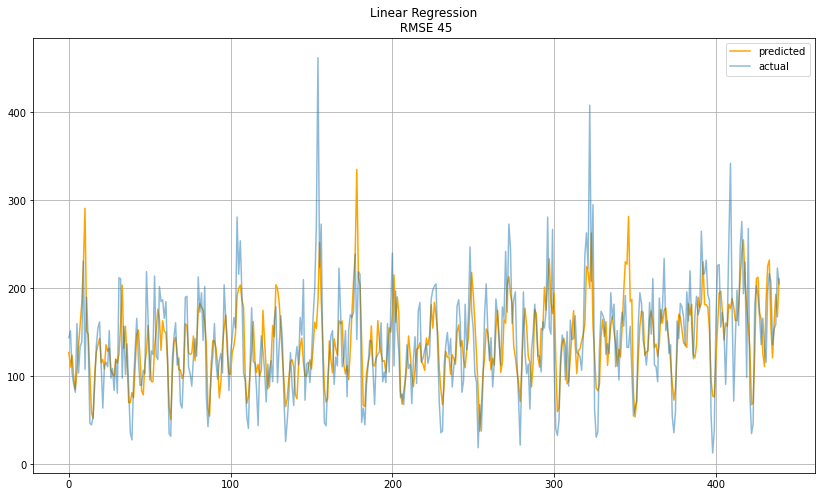

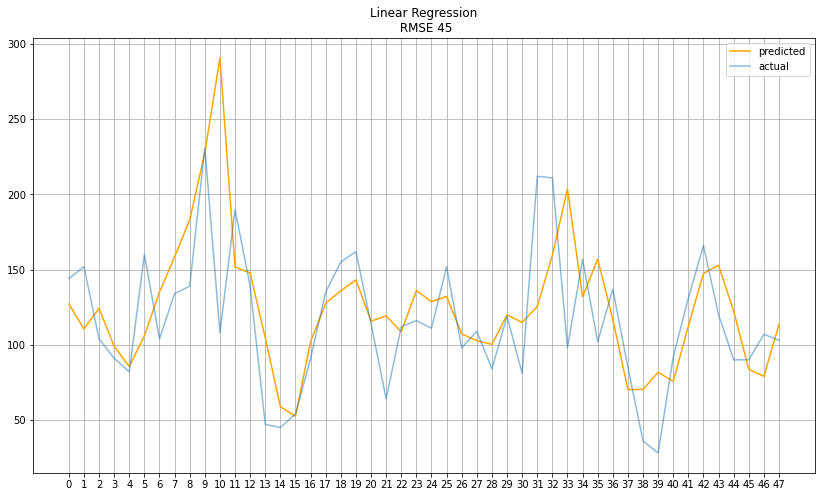

In [46]:
make_graph(lr_pred, 'Linear Regression', lr_rmse_test)

**Ridge**

In [47]:
ridge_pred = grid_ridge.predict(X_test)

ridge_rmse_test = mean_squared_error(y_test, ridge_pred, squared=False)
model_rmse_test.append(ridge_rmse_test)
print(f'RMSE on the test data: {ridge_rmse_test}')

RMSE on the test data: 44.960104397391646


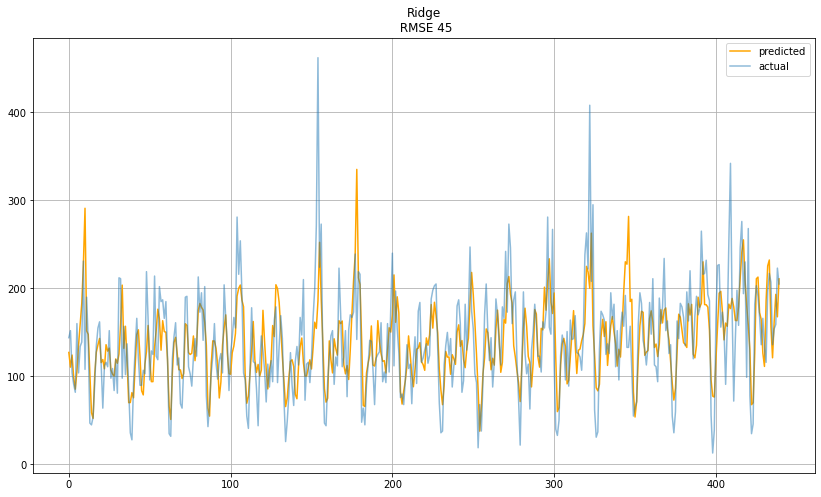

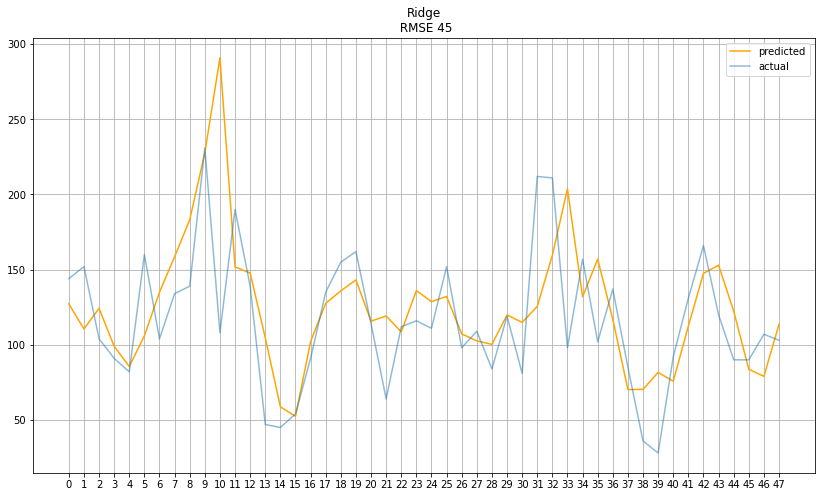

In [48]:
make_graph(ridge_pred, 'Ridge', ridge_rmse_test)

**Lasso**

In [49]:
lasso_pred = grid_lasso.predict(X_test)

lasso_rmse_test = mean_squared_error(y_test, lasso_pred, squared=False)
model_rmse_test.append(lasso_rmse_test)
print(f'RMSE on the test data: {lasso_rmse_test}')

RMSE on the test data: 44.964709713161405


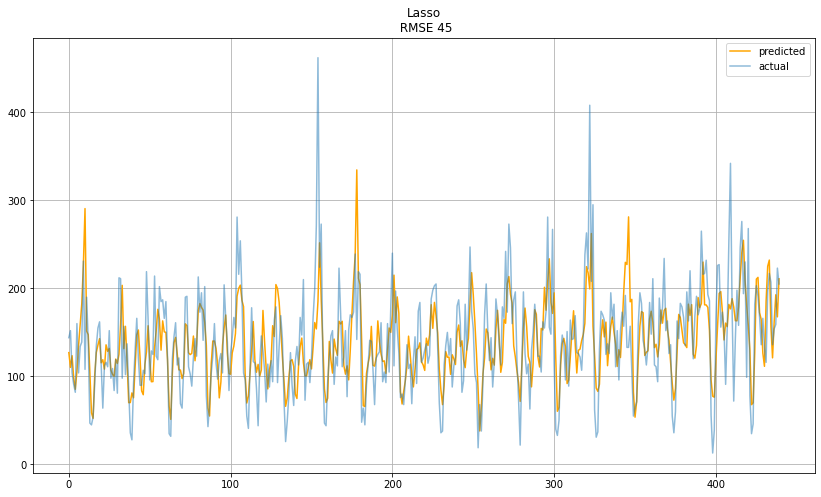

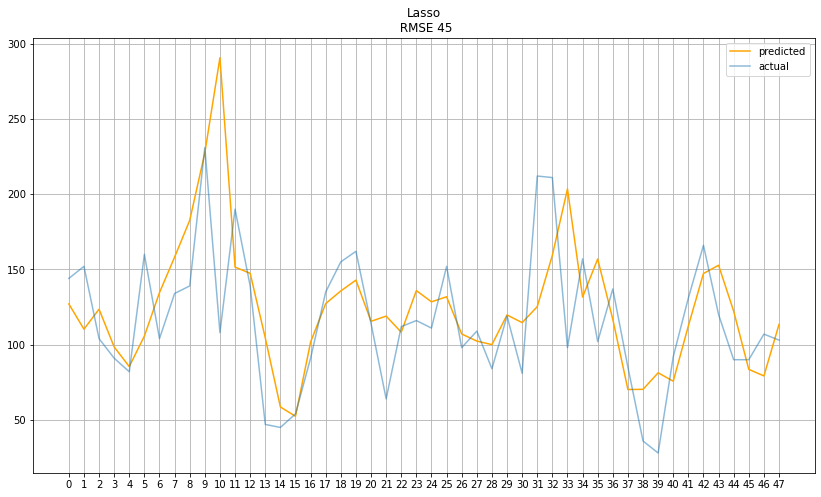

In [50]:
make_graph(lasso_pred, 'Lasso', lasso_rmse_test)

**CatBoost**

In [51]:
catboost_pred = grid_catboost.predict(X_test)

catboost_rmse_test = mean_squared_error(y_test, catboost_pred, squared=False)
model_rmse_test.append(catboost_rmse_test)
print(f'RMSE of Catboost on the test data: {catboost_rmse_test}')

RMSE of Catboost on the test data: 43.27559589811174


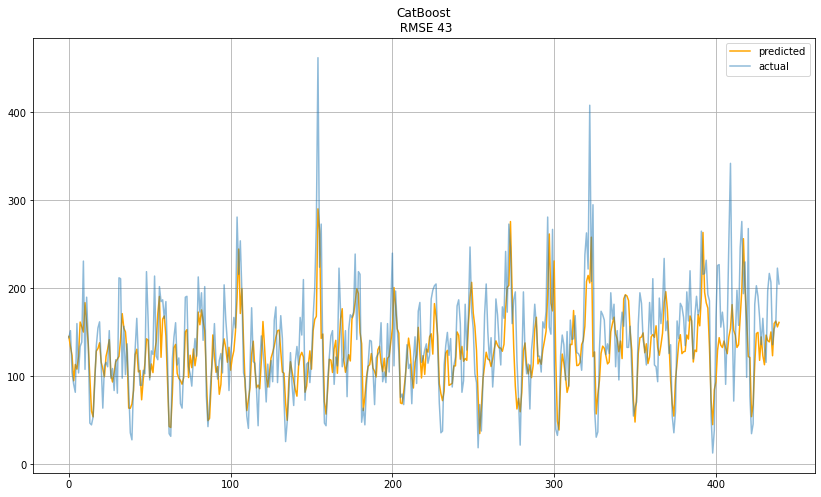

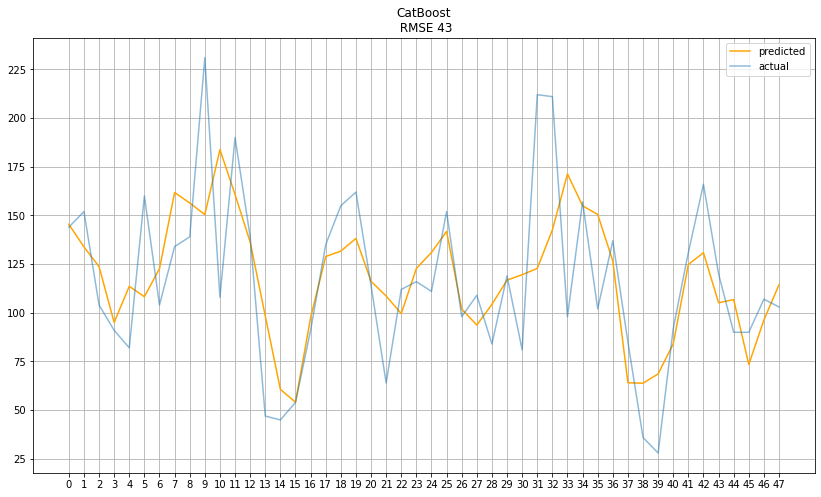

In [52]:
make_graph(catboost_pred, 'CatBoost', catboost_rmse_test)

**LightGBM**

In [53]:
lgbm_pred = grid_lgbm.predict(X_test)

lgbm_rmse_test = mean_squared_error(y_test, lgbm_pred, squared=False)
model_rmse_test.append(lgbm_rmse_test)
print(f'RMSE of LightGBM on the test data: {lgbm_rmse_test}')

RMSE of LightGBM on the test data: 42.45116042108723


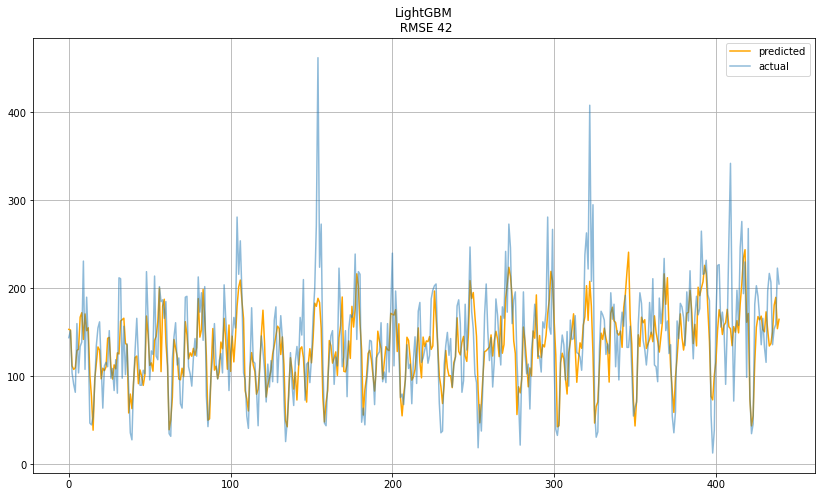

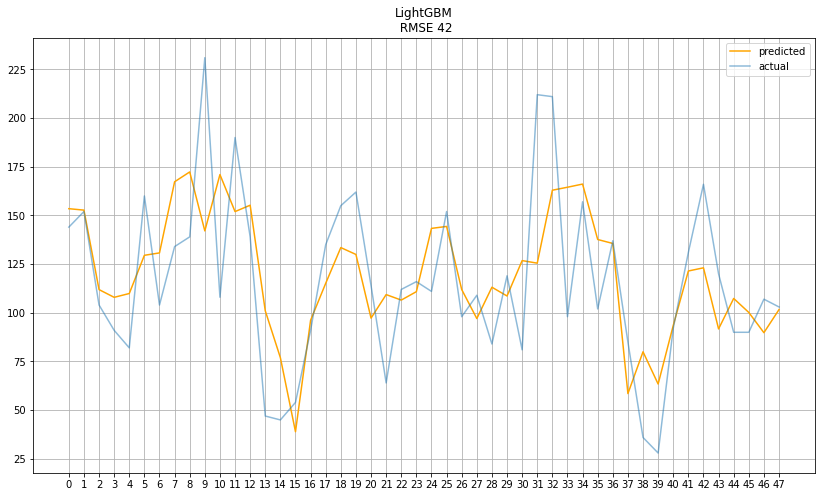

In [54]:
make_graph(lgbm_pred, 'LightGBM', lgbm_rmse_test)

### Model comparison

Let's create a table with the results and compare the models.

In [55]:
model_comparison = pd.DataFrame(
    {
    'model_name': model_name, 
    'train_RMSE': model_rmse_train, 
    'test_RMSE' : model_rmse_test
    }
).sort_values(by='test_RMSE').reset_index(drop=True)

model_comparison.style.highlight_min(
    ['train_RMSE', 'test_RMSE'], 
    color='lightgreen', 
    axis=0
)

,model_name,train_RMSE,test_RMSE
0,LightGBM,27.827277,42.451160
1,CatBoostRegressor,26.968739,43.275596
2,LinearRegression,27.563639,44.958903
3,Ridge,27.563427,44.960104
4,Lasso,27.561863,44.964710


The `LightGBM` and `CatBoost` models showed good prediction quality. `LightGBM` showed the best result on the test data. `Linear Regression`, `Lasso` and `Ridge` regression models showed approximately the same result.

## Sanity Check

Let's check the models for adequacy by comparing the RMSE of the trained model with the RMSE predicted by the previous value of the series.

In [56]:
train_control, test_control = train_test_split(df, shuffle=False, test_size=0.1)

pred_previous = test_control.shift(fill_value=train_control['num_orders'].iloc[-1])
prev_rmse = mean_squared_error(test_control, pred_previous, squared=False)
print(f'RMSE predicted by the previous value of the series: {prev_rmse}')

RMSE predicted by the previous value of the series: 56.391949774196924


All our models passed the sanity check as their RMSE is lower than predicted by the previous value of the series.

## Conclusion

In the course of the project, we reviewed the data and resampled it by one hour. During the analysis, we used the moving average method to reduce fluctuations and to identify trends. We made a decomposition of the time series, studied trends and seasonality for different periods, and checked the time series for stationarity.

After that, we created the features necessary for training the models and split the data into two sets (training and test) in a ratio of 90:10. Then we trained `Linear Regression`, `Ridge Regression`, `Lasso`, `CatBoost` and `LightGBM` models, and checked the quality of the models on test data using the RMSE metric.

LightGBM showed the best RMSE result (42.451160) on the test data. It is followed by the CatBoost model with the RMSE result (43.275596).

Thus, to predict the number of taxi orders for the next hour, the LightGBM model can be recommended.

We also found a relationship between seasonality and the time of day. Starting from midnight, we can observe a decline in the number of orders, and from 6 am an increase begins. 